In [1]:
!nvidia-smi

Mon May 13 13:06:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import cv2
import imutils
from sklearn.utils import shuffle

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Dropout,Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [5]:
train_data_gen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale = 1./255)
valid_data_gen = ImageDataGenerator(rescale = 1./255)

In [6]:
train_generator = train_data_gen.flow_from_directory('/content/gdrive/MyDrive/Training/dataset/Training/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 6212 images belonging to 4 classes.


In [7]:
test_generator = test_data_gen.flow_from_directory('/content/gdrive/MyDrive/Training/dataset/Testing/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 603 images belonging to 4 classes.


In [8]:
valid_generator = valid_data_gen.flow_from_directory('/content/gdrive/MyDrive/Training/dataset/Validating/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 859 images belonging to 4 classes.


In [9]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}
print(class_name)

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


In [10]:
# Load pre-trained VGG19 application model
base_model = VGG19(input_shape=(240, 240, 3), include_top=False, weights='imagenet')

# Freeze the pre-trained weights
base_model.trainable = False

# Flatten the output of VGG19 base
flatten_layer = Flatten()(base_model.output)

# Add my own classification layers
class_1 = Dense(4608, activation = 'relu')(flatten_layer)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)

# Output layer
output_layer = Dense(4, activation='softmax')(class_2)

# Create model
model_1 = Model(inputs=base_model.input, outputs=output_layer)

80134624/80134624 [==============================] - 0s 0us/step


In [11]:
# callback
filepath = 'model_1.keras'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=8)
mcp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
rp = ReduceLROnPlateau(monitor='val_accuarcy', patience=5, verbose = 1, factor = 0.5, min_lr = 0.001)

In [12]:
# optimizer
learning_rate = 0.001
momentum = 0.9
nesterov = True
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
#sgd = SGD(learning_rate=0.001, decay = 1e-6, momentum = 0.9, nesterov = True)
adam = Adam(learning_rate=0.001)
model_1.compile( optimizer = sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# Print model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 1.7071 - accuracy: 0.2906

10/10 [==============================] - 301s 29s/step - loss: 1.7071 - accuracy: 0.2906 - val_loss: 1.3506 - val_accuracy: 0.2969 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 1.4413 - accuracy: 0.3313

10/10 [==============================] - 71s 7s/step - loss: 1.4413 - accuracy: 0.3313 - val_loss: 1.1961 - val_accuracy: 0.5006 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 1.3206 - accuracy: 0.3594

10/10 [==============================] - 67s 7s/step - loss: 1.3206 - accuracy: 0.3594 - val_loss: 1.1267 - val_accuracy: 0.5274 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 1.4771 - accuracy: 0.3870

10/10 [==============================] - 64s 6s/step - loss: 1.4771 - accuracy: 0.3870 - val_loss: 1.0642 - val_accuracy: 0.6566 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - ETA: 0s - loss: 1.3627 - accuracy: 0.3406

10/10 [==============================] - 55s 6s/step - loss: 1.3627 - accuracy: 0.3406 - val_loss: 1.3108 - val_accuracy: 0.3655 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - ETA: 0s - loss: 1.2660 - accuracy: 0.4375

10/10 [==============================] - 55s 6s/step - loss: 1.2660 - accuracy: 0.4375 - val_loss: 1.0121 - val_accuracy: 0.6054 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - ETA: 0s - loss: 1.1723 - accuracy: 0.4625

10/10 [==============================] - 49s 5s/step - loss: 1.1723 - accuracy: 0.4625 - val_loss: 0.9410 - val_accuracy: 0.6054 - lr: 0.0010
Epoch 8/20
10/10 [==============================] - ETA: 0s - loss: 1.1344 - accuracy: 0.4906

10/10 [==============================] - 47s 5s/step - loss: 1.1344 - accuracy: 0.4906 - val_loss: 0.9654 - val_accuracy: 0.5949 - lr: 0.0010
Epoch 9/20
10/10 [==============================] - ETA: 0s - loss: 1.0866 - accuracy: 0.5094

10/10 [==============================] - 48s 5s/step - loss: 1.0866 - accuracy: 0.5094 - val_loss: 0.8642 - val_accuracy: 0.6403 - lr: 0.0010
Epoch 10/20
10/10 [==============================] - ETA: 0s - loss: 1.0463 - accuracy: 0.5188

10/10 [==============================] - 46s 5s/step - loss: 1.0463 - accuracy: 0.5188 - val_loss: 1.0315 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 11/20
10/10 [==============================] - ETA: 0s - loss: 1.1107 - accuracy: 0.5094

10/10 [==============================] - 42s 4s/step - loss: 1.1107 - accuracy: 0.5094 - val_loss: 0.9407 - val_accuracy: 0.5763 - lr: 0.0010
Epoch 12/20
10/10 [==============================] - ETA: 0s - loss: 0.9919 - accuracy: 0.5594

10/10 [==============================] - 38s 4s/step - loss: 0.9919 - accuracy: 0.5594 - val_loss: 0.7920 - val_accuracy: 0.7183 - lr: 0.0010
Epoch 13/20
10/10 [==============================] - ETA: 0s - loss: 1.0955 - accuracy: 0.5094

10/10 [==============================] - 42s 4s/step - loss: 1.0955 - accuracy: 0.5094 - val_loss: 0.9615 - val_accuracy: 0.5204 - lr: 0.0010
Epoch 14/20
10/10 [==============================] - ETA: 0s - loss: 1.0264 - accuracy: 0.5406

10/10 [==============================] - 39s 4s/step - loss: 1.0264 - accuracy: 0.5406 - val_loss: 0.7648 - val_accuracy: 0.7136 - lr: 0.0010
Epoch 15/20
10/10 [==============================] - ETA: 0s - loss: 1.0526 - accuracy: 0.5156

10/10 [==============================] - 37s 4s/step - loss: 1.0526 - accuracy: 0.5156 - val_loss: 0.8875 - val_accuracy: 0.5378 - lr: 0.0010
Epoch 16/20
10/10 [==============================] - ETA: 0s - loss: 0.9495 - accuracy: 0.5625

10/10 [==============================] - 37s 4s/step - loss: 0.9495 - accuracy: 0.5625 - val_loss: 0.8125 - val_accuracy: 0.6752 - lr: 0.0010
Epoch 17/20
10/10 [==============================] - ETA: 0s - loss: 0.9661 - accuracy: 0.5719

10/10 [==============================] - 33s 3s/step - loss: 0.9661 - accuracy: 0.5719 - val_loss: 0.8171 - val_accuracy: 0.6275 - lr: 0.0010
Epoch 18/20
10/10 [==============================] - ETA: 0s - loss: 0.9781 - accuracy: 0.5813

10/10 [==============================] - 34s 3s/step - loss: 0.9781 - accuracy: 0.5813 - val_loss: 0.7650 - val_accuracy: 0.7043 - lr: 0.0010
Epoch 19/20
10/10 [==============================] - ETA: 0s - loss: 0.9365 - accuracy: 0.5906

10/10 [==============================] - 31s 3s/step - loss: 0.9365 - accuracy: 0.5906 - val_loss: 0.7938 - val_accuracy: 0.6356 - lr: 0.0010
Epoch 20/20
10/10 [==============================] - ETA: 0s - loss: 0.9359 - accuracy: 0.5813

10/10 [==============================] - 31s 3s/step - loss: 0.9359 - accuracy: 0.5813 - val_loss: 0.8326 - val_accuracy: 0.5891 - lr: 0.0010


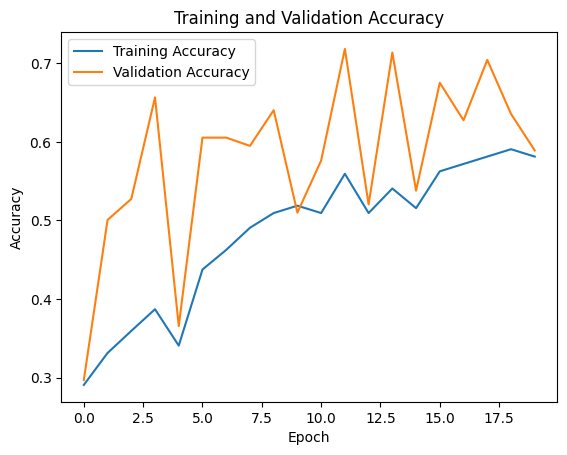

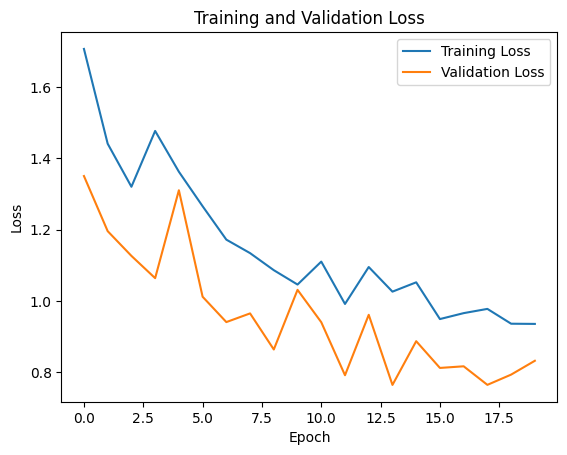

In [13]:
from tensorflow.keras.callbacks import TensorBoard
# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="./logs")
# Train the model with TensorBoard callback
history = model_1.fit(train_generator, steps_per_epoch=10, epochs=20, callbacks=[es, rp, tensorboard_callback], validation_data=valid_generator)
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
model_1.save_weights(filepath="/content/gdrive/MyDrive/Training/model_weights/vgg19_model_1.weights.h5", overwrite=True)

In [16]:
model_1.load_weights("/content/gdrive/MyDrive/Training/model_weights/vgg19_model_1.weights.h5")
vgg_val_eval_1 = model_1.evaluate(valid_generator)
vgg_test_eval_1 = model_1.evaluate(test_generator)
print(f'Validation Loss: {vgg_val_eval_1[0]}')
print(f'Validation Acc: {vgg_val_eval_1[1]}')
print(f'Testing Loss: {vgg_test_eval_1[0]}')
print(f'Testing Acc: {vgg_test_eval_1[1]}')

19/19 [==============================] - 137s 8s/step - loss: 1.0913 - accuracy: 0.5390
Validation Loss: 0.832568347454071
Validation Acc: 0.5890570282936096
Testing Loss: 1.0913465023040771
Testing Acc: 0.5389717817306519


In [17]:
#building new model
base_model = VGG19(include_top = False, input_shape=(240,240,3))

# Flatten the output of VGG19 base
flatten_layer = Flatten()(base_model.output)

# Add my own classification layers
class_1 = Dense(4608, activation = 'relu')(flatten_layer)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)

# Output layer
output_layer = Dense(4, activation='softmax')(class_2)

# Create model
model_2 = Model(inputs=base_model.input, outputs=output_layer)
model_2.load_weights('/content/gdrive/MyDrive/Training/model_weights/vgg19_model_1.weights.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

In [18]:
# optimizer
learning_rate = 0.001
momentum = 0.9
nesterov = True
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
model_2.compile( optimizer = sgd, loss='categorical_crossentropy', metrics=['accuracy'])
print(model_2.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 1.4465 - accuracy: 0.4938

10/10 [==============================] - 30s 3s/step - loss: 1.4465 - accuracy: 0.4938 - val_loss: 0.9685 - val_accuracy: 0.5367 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.9025 - accuracy: 0.6187

10/10 [==============================] - 27s 3s/step - loss: 0.9025 - accuracy: 0.6187 - val_loss: 1.0675 - val_accuracy: 0.5029 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.8674 - accuracy: 0.6125

10/10 [==============================] - 29s 3s/step - loss: 0.8674 - accuracy: 0.6125 - val_loss: 0.7281 - val_accuracy: 0.6857 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.8313 - accuracy: 0.6438

10/10 [==============================] - 24s 3s/step - loss: 0.8313 - accuracy: 0.6438 - val_loss: 0.6976 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - ETA: 0s - loss: 0.8796 - accuracy: 0.6344

10/10 [==============================] - 25s 3s/step - loss: 0.8796 - accuracy: 0.6344 - val_loss: 0.8966 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - ETA: 0s - loss: 0.8806 - accuracy: 0.6094

10/10 [==============================] - 25s 3s/step - loss: 0.8806 - accuracy: 0.6094 - val_loss: 0.6904 - val_accuracy: 0.7183 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - ETA: 0s - loss: 0.8461 - accuracy: 0.6656

10/10 [==============================] - 26s 3s/step - loss: 0.8461 - accuracy: 0.6656 - val_loss: 0.5817 - val_accuracy: 0.7602 - lr: 0.0010
Epoch 8/20
10/10 [==============================] - ETA: 0s - loss: 0.7580 - accuracy: 0.6906

10/10 [==============================] - 25s 3s/step - loss: 0.7580 - accuracy: 0.6906 - val_loss: 0.6929 - val_accuracy: 0.6985 - lr: 0.0010
Epoch 9/20
10/10 [==============================] - ETA: 0s - loss: 0.7863 - accuracy: 0.6406

10/10 [==============================] - 24s 2s/step - loss: 0.7863 - accuracy: 0.6406 - val_loss: 0.6589 - val_accuracy: 0.7276 - lr: 0.0010
Epoch 10/20
10/10 [==============================] - ETA: 0s - loss: 0.8378 - accuracy: 0.6281

10/10 [==============================] - 22s 2s/step - loss: 0.8378 - accuracy: 0.6281 - val_loss: 0.6020 - val_accuracy: 0.7579 - lr: 0.0010
Epoch 11/20
10/10 [==============================] - ETA: 0s - loss: 0.7618 - accuracy: 0.6906

10/10 [==============================] - 20s 2s/step - loss: 0.7618 - accuracy: 0.6906 - val_loss: 0.5394 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 12/20
10/10 [==============================] - ETA: 0s - loss: 0.6769 - accuracy: 0.7063

10/10 [==============================] - 19s 2s/step - loss: 0.6769 - accuracy: 0.7063 - val_loss: 0.5577 - val_accuracy: 0.7870 - lr: 0.0010
Epoch 13/20
10/10 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.7000

10/10 [==============================] - 17s 2s/step - loss: 0.6723 - accuracy: 0.7000 - val_loss: 0.6031 - val_accuracy: 0.7672 - lr: 0.0010
Epoch 14/20
10/10 [==============================] - ETA: 0s - loss: 0.8261 - accuracy: 0.6875

10/10 [==============================] - 19s 2s/step - loss: 0.8261 - accuracy: 0.6875 - val_loss: 0.7264 - val_accuracy: 0.7346 - lr: 0.0010
Epoch 15/20
10/10 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.6969

10/10 [==============================] - 18s 2s/step - loss: 0.7059 - accuracy: 0.6969 - val_loss: 0.5058 - val_accuracy: 0.7998 - lr: 0.0010
Epoch 16/20
10/10 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.6812

10/10 [==============================] - 18s 2s/step - loss: 0.7019 - accuracy: 0.6812 - val_loss: 0.7407 - val_accuracy: 0.7159 - lr: 0.0010
Epoch 17/20
10/10 [==============================] - ETA: 0s - loss: 0.6165 - accuracy: 0.7625

10/10 [==============================] - 18s 2s/step - loss: 0.6165 - accuracy: 0.7625 - val_loss: 0.5761 - val_accuracy: 0.7509 - lr: 0.0010
Epoch 18/20
10/10 [==============================] - ETA: 0s - loss: 0.6366 - accuracy: 0.7375

10/10 [==============================] - 16s 2s/step - loss: 0.6366 - accuracy: 0.7375 - val_loss: 0.5290 - val_accuracy: 0.7788 - lr: 0.0010
Epoch 19/20
10/10 [==============================] - ETA: 0s - loss: 0.7452 - accuracy: 0.7219

10/10 [==============================] - 16s 2s/step - loss: 0.7452 - accuracy: 0.7219 - val_loss: 0.4936 - val_accuracy: 0.7893 - lr: 0.0010
Epoch 20/20
10/10 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.7344

10/10 [==============================] - 17s 2s/step - loss: 0.6746 - accuracy: 0.7344 - val_loss: 0.5377 - val_accuracy: 0.7870 - lr: 0.0010


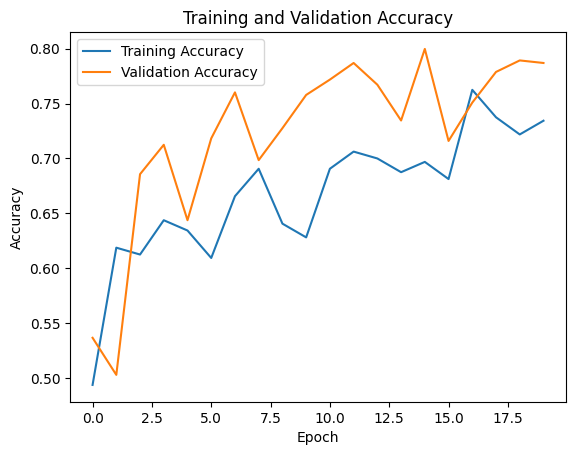

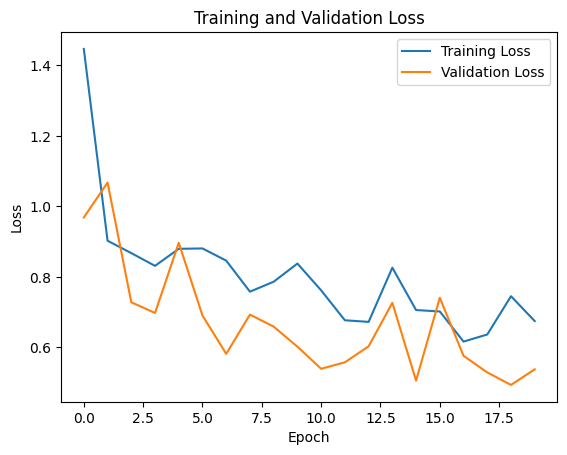

In [19]:
from tensorflow.keras.callbacks import TensorBoard
# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="./logs")
# Train the model with TensorBoard callback
history = model_2.fit(train_generator, steps_per_epoch=10, epochs=20, callbacks=[es, rp, tensorboard_callback], validation_data=valid_generator)
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
model_2.save_weights(filepath="/content/gdrive/MyDrive/Training/model_weights/vgg19_model_2.weights.h5", overwrite=True)

In [21]:
model_2.load_weights("/content/gdrive/MyDrive/Training/model_weights/vgg19_model_2.weights.h5")
vgg_val_eval_2 = model_2.evaluate(valid_generator)
vgg_test_eval_2 = model_2.evaluate(test_generator)
print(f'Validation Loss: {vgg_val_eval_2[0]}')
print(f'Validation Acc: {vgg_val_eval_2[1]}')
print(f'Testing Loss: {vgg_test_eval_2[0]}')
print(f'Testing Acc: {vgg_test_eval_2[1]}')

19/19 [==============================] - 4s 204ms/step - loss: 0.7820 - accuracy: 0.7214
Validation Loss: 0.5377345681190491
Validation Acc: 0.786961555480957
Testing Loss: 0.7819547653198242
Testing Acc: 0.7213930487632751


# unfreeze some other layers

In [22]:
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [23]:
#building new model
base_model = VGG19(include_top = False, input_shape=(240,240,3))

# Flatten the output of VGG19 base
flatten_layer = Flatten()(base_model.output)

# Add my own classification layers
class_1 = Dense(4608, activation = 'relu')(flatten_layer)
drop_out = Dropout(0.3)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)

# Output layer
output_layer = Dense(4, activation='softmax')(class_2)

# Create model
model_3 = Model(inputs=base_model.input, outputs=output_layer)
model_3.load_weights('/content/gdrive/MyDrive/Training/model_weights/vgg19_model_2.weights.h5')
set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3','block5_conv1','block5_conv2']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

In [24]:
# optimizer
learning_rate = 0.001
momentum = 0.9
nesterov = True
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)

model_3.compile( optimizer = sgd, loss='categorical_crossentropy', metrics=['accuracy'])
print(model_3.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 1.2832 - accuracy: 0.5656

10/10 [==============================] - 18s 2s/step - loss: 1.2832 - accuracy: 0.5656 - val_loss: 1.0814 - val_accuracy: 0.5576 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 1.0410 - accuracy: 0.5437

10/10 [==============================] - 17s 2s/step - loss: 1.0410 - accuracy: 0.5437 - val_loss: 0.8941 - val_accuracy: 0.5972 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.7791 - accuracy: 0.6938

10/10 [==============================] - 17s 2s/step - loss: 0.7791 - accuracy: 0.6938 - val_loss: 0.6130 - val_accuracy: 0.7416 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.8159 - accuracy: 0.6656

10/10 [==============================] - 20s 2s/step - loss: 0.8159 - accuracy: 0.6656 - val_loss: 0.5750 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - ETA: 0s - loss: 0.6170 - accuracy: 0.7406

10/10 [==============================] - 15s 2s/step - loss: 0.6170 - accuracy: 0.7406 - val_loss: 0.4785 - val_accuracy: 0.8161 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - ETA: 0s - loss: 0.6013 - accuracy: 0.7625

10/10 [==============================] - 21s 2s/step - loss: 0.6013 - accuracy: 0.7625 - val_loss: 0.5064 - val_accuracy: 0.7963 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - ETA: 0s - loss: 0.5814 - accuracy: 0.7594

10/10 [==============================] - 17s 2s/step - loss: 0.5814 - accuracy: 0.7594 - val_loss: 0.4313 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 8/20
10/10 [==============================] - ETA: 0s - loss: 0.5929 - accuracy: 0.7437

10/10 [==============================] - 14s 1s/step - loss: 0.5929 - accuracy: 0.7437 - val_loss: 0.7070 - val_accuracy: 0.7427 - lr: 0.0010
Epoch 9/20
10/10 [==============================] - ETA: 0s - loss: 0.6294 - accuracy: 0.7705

10/10 [==============================] - 15s 2s/step - loss: 0.6294 - accuracy: 0.7705 - val_loss: 0.4600 - val_accuracy: 0.8161 - lr: 0.0010
Epoch 10/20
10/10 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.7563

10/10 [==============================] - 15s 2s/step - loss: 0.5797 - accuracy: 0.7563 - val_loss: 0.5812 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 11/20
10/10 [==============================] - ETA: 0s - loss: 0.5502 - accuracy: 0.8031

10/10 [==============================] - 14s 1s/step - loss: 0.5502 - accuracy: 0.8031 - val_loss: 0.4699 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 12/20
10/10 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.7812

10/10 [==============================] - 15s 2s/step - loss: 0.5761 - accuracy: 0.7812 - val_loss: 0.4643 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 13/20
10/10 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.8250

10/10 [==============================] - 19s 2s/step - loss: 0.4671 - accuracy: 0.8250 - val_loss: 0.4197 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 14/20
10/10 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.7844

10/10 [==============================] - 15s 2s/step - loss: 0.5256 - accuracy: 0.7844 - val_loss: 0.4637 - val_accuracy: 0.8289 - lr: 0.0010
Epoch 15/20
10/10 [==============================] - ETA: 0s - loss: 0.4473 - accuracy: 0.8375

10/10 [==============================] - 14s 1s/step - loss: 0.4473 - accuracy: 0.8375 - val_loss: 0.5508 - val_accuracy: 0.8021 - lr: 0.0010
Epoch 16/20
10/10 [==============================] - ETA: 0s - loss: 0.4507 - accuracy: 0.8125

10/10 [==============================] - 19s 2s/step - loss: 0.4507 - accuracy: 0.8125 - val_loss: 0.4119 - val_accuracy: 0.8405 - lr: 0.0010
Epoch 17/20
10/10 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.7844

10/10 [==============================] - 15s 1s/step - loss: 0.5529 - accuracy: 0.7844 - val_loss: 0.3636 - val_accuracy: 0.8545 - lr: 0.0010
Epoch 18/20
10/10 [==============================] - ETA: 0s - loss: 0.5755 - accuracy: 0.7750

10/10 [==============================] - 13s 1s/step - loss: 0.5755 - accuracy: 0.7750 - val_loss: 0.4526 - val_accuracy: 0.8254 - lr: 0.0010
Epoch 19/20
10/10 [==============================] - ETA: 0s - loss: 0.5189 - accuracy: 0.8313

10/10 [==============================] - 14s 1s/step - loss: 0.5189 - accuracy: 0.8313 - val_loss: 0.3931 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 20/20
10/10 [==============================] - ETA: 0s - loss: 0.4883 - accuracy: 0.8219

10/10 [==============================] - 18s 2s/step - loss: 0.4883 - accuracy: 0.8219 - val_loss: 0.3652 - val_accuracy: 0.8603 - lr: 0.0010


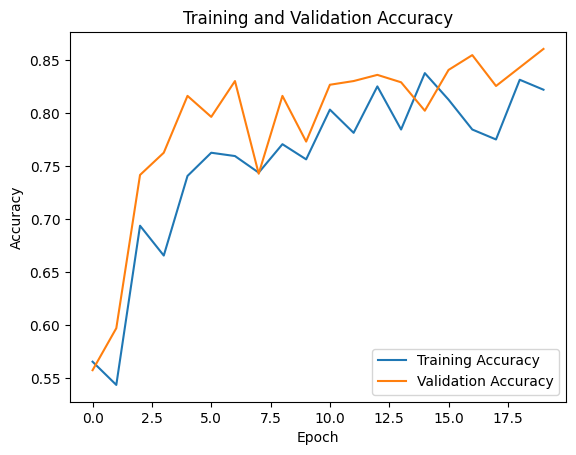

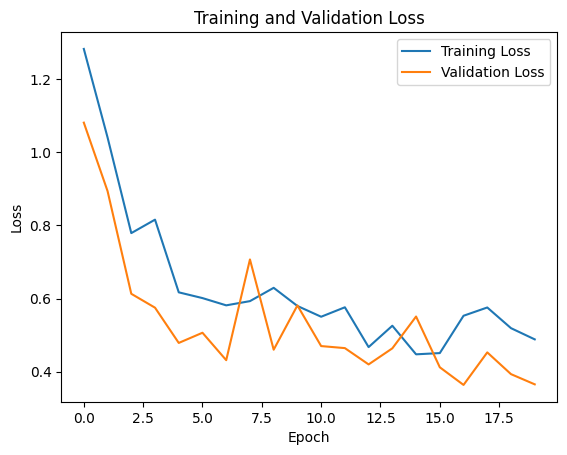

In [25]:
from tensorflow.keras.callbacks import TensorBoard
# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="./logs")
# Train the model with TensorBoard callback
history = model_3.fit(train_generator, steps_per_epoch=10, epochs=20, callbacks=[es, rp, tensorboard_callback], validation_data=valid_generator)
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
model_3.save_weights(filepath="/content/gdrive/MyDrive/Training/model_weights/vgg19_model_3.weights.h5", overwrite=True)

In [27]:
model_3.load_weights("/content/gdrive/MyDrive/Training/model_weights/vgg19_model_3.weights.h5")
vgg_val_eval_3 = model_3.evaluate(valid_generator)
vgg_test_eval_3 = model_3.evaluate(test_generator)
print(f'Validation Loss: {vgg_val_eval_3[0]}')
print(f'Validation Acc: {vgg_val_eval_3[1]}')
print(f'Testing Loss: {vgg_test_eval_3[0]}')
print(f'Testing Acc: {vgg_test_eval_3[1]}')

19/19 [==============================] - 5s 246ms/step - loss: 0.6670 - accuracy: 0.7794
Validation Loss: 0.36518755555152893
Validation Acc: 0.8603026866912842
Testing Loss: 0.6669757962226868
Testing Acc: 0.7794361710548401


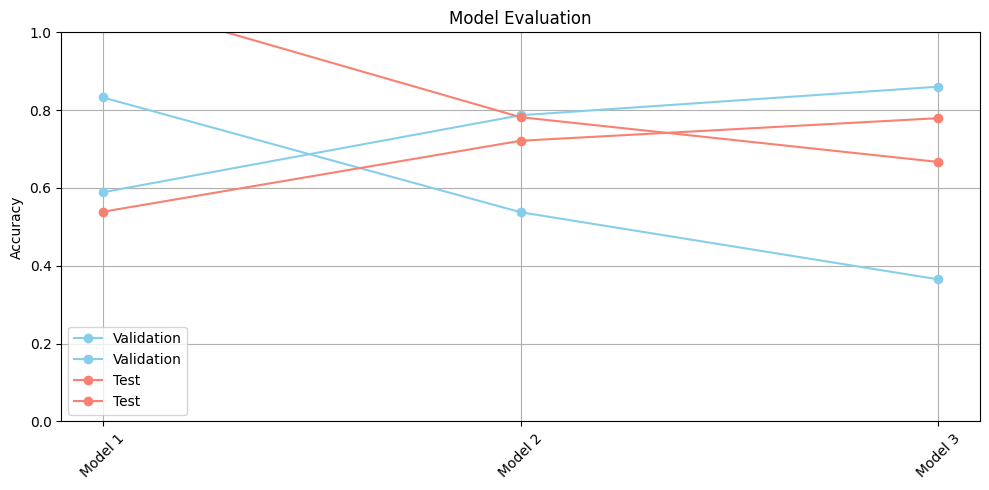

In [28]:
# Evaluation results
val_eval = [vgg_val_eval_1, vgg_val_eval_2, vgg_val_eval_3]
test_eval = [vgg_test_eval_1, vgg_test_eval_2, vgg_test_eval_3]

# Models labels
models = ['Model 1', 'Model 2', 'Model 3']

# Plotting
plt.figure(figsize=(10, 5))

# Validation results
plt.plot(models, val_eval, marker='o', linestyle='-', color='skyblue', label='Validation')
# Test results
plt.plot(models, test_eval, marker='o', linestyle='-', color='salmon', label='Test')

plt.title('Model Evaluation')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# unfreeze some other layers

In [29]:
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_3',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [33]:
#building new model
base_model = VGG19(include_top = False, input_shape=(240,240,3))

# Flatten the output of VGG19 base
flatten_layer = Flatten()(base_model.output)

# Add my own classification layers
class_1 = Dense(4608, activation = 'relu')(flatten_layer)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)

# Output layer
output_layer = Dense(4, activation='softmax')(class_2)

# Create model
model_4 = Model(inputs=base_model.input, outputs=output_layer)
model_4.load_weights('/content/gdrive/MyDrive/Training/model_weights/vgg19_model_3.weights.h5')
set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3','block5_conv2','block5_conv1','block5_pool']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

In [34]:
# optimizer
learning_rate = 0.001
momentum = 0.9
nesterov = True
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)

model_4.compile( optimizer = sgd, loss='categorical_crossentropy', metrics=['accuracy'])
print(model_4.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.4949 - accuracy: 0.7937

10/10 [==============================] - 15s 1s/step - loss: 0.4949 - accuracy: 0.7937 - val_loss: 0.4646 - val_accuracy: 0.8196 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.3663 - accuracy: 0.8594

10/10 [==============================] - 13s 1s/step - loss: 0.3663 - accuracy: 0.8594 - val_loss: 0.4646 - val_accuracy: 0.8324 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.5316 - accuracy: 0.8031

10/10 [==============================] - 13s 1s/step - loss: 0.5316 - accuracy: 0.8031 - val_loss: 0.5148 - val_accuracy: 0.8172 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.8156

10/10 [==============================] - 13s 1s/step - loss: 0.4319 - accuracy: 0.8156 - val_loss: 0.4318 - val_accuracy: 0.8335 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - ETA: 0s - loss: 0.4407 - accuracy: 0.8281

10/10 [==============================] - 17s 2s/step - loss: 0.4407 - accuracy: 0.8281 - val_loss: 0.3572 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - ETA: 0s - loss: 0.4160 - accuracy: 0.8625

10/10 [==============================] - 13s 1s/step - loss: 0.4160 - accuracy: 0.8625 - val_loss: 0.4717 - val_accuracy: 0.8254 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - ETA: 0s - loss: 0.4513 - accuracy: 0.8344

10/10 [==============================] - 13s 1s/step - loss: 0.4513 - accuracy: 0.8344 - val_loss: 0.4463 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 8/20
10/10 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.8313

10/10 [==============================] - 14s 1s/step - loss: 0.4609 - accuracy: 0.8313 - val_loss: 0.5033 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 9/20
10/10 [==============================] - ETA: 0s - loss: 0.5220 - accuracy: 0.8062

10/10 [==============================] - 14s 1s/step - loss: 0.5220 - accuracy: 0.8062 - val_loss: 0.2681 - val_accuracy: 0.8859 - lr: 0.0010
Epoch 10/20
10/10 [==============================] - ETA: 0s - loss: 0.4222 - accuracy: 0.8344

10/10 [==============================] - 13s 1s/step - loss: 0.4222 - accuracy: 0.8344 - val_loss: 0.2724 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 11/20
10/10 [==============================] - ETA: 0s - loss: 0.4287 - accuracy: 0.8469

10/10 [==============================] - 13s 1s/step - loss: 0.4287 - accuracy: 0.8469 - val_loss: 0.3150 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 12/20
10/10 [==============================] - ETA: 0s - loss: 0.4370 - accuracy: 0.8500

10/10 [==============================] - 13s 1s/step - loss: 0.4370 - accuracy: 0.8500 - val_loss: 0.3806 - val_accuracy: 0.8545 - lr: 0.0010
Epoch 13/20
10/10 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.8656

10/10 [==============================] - 12s 1s/step - loss: 0.3796 - accuracy: 0.8656 - val_loss: 0.3261 - val_accuracy: 0.8696 - lr: 0.0010
Epoch 14/20
10/10 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.8313

10/10 [==============================] - 13s 1s/step - loss: 0.5103 - accuracy: 0.8313 - val_loss: 0.5074 - val_accuracy: 0.8079 - lr: 0.0010
Epoch 15/20
10/10 [==============================] - ETA: 0s - loss: 0.4345 - accuracy: 0.8438

10/10 [==============================] - 13s 1s/step - loss: 0.4345 - accuracy: 0.8438 - val_loss: 0.3286 - val_accuracy: 0.8696 - lr: 0.0010
Epoch 16/20
10/10 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.8687

10/10 [==============================] - 16s 2s/step - loss: 0.4135 - accuracy: 0.8687 - val_loss: 0.3571 - val_accuracy: 0.8603 - lr: 0.0010
Epoch 17/20
10/10 [==============================] - ETA: 0s - loss: 0.4452 - accuracy: 0.8531

10/10 [==============================] - 13s 1s/step - loss: 0.4452 - accuracy: 0.8531 - val_loss: 0.3103 - val_accuracy: 0.8743 - lr: 0.0010
Epoch 17: early stopping


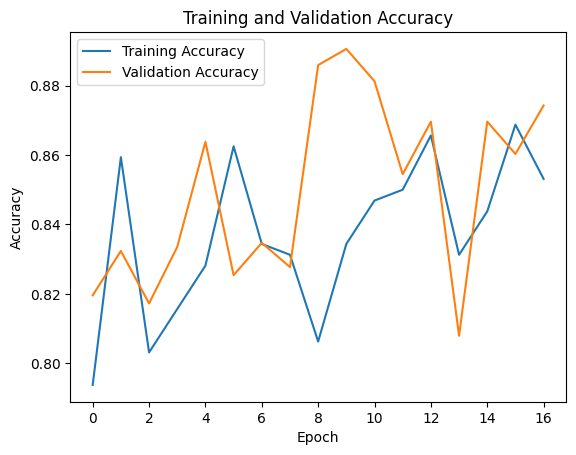

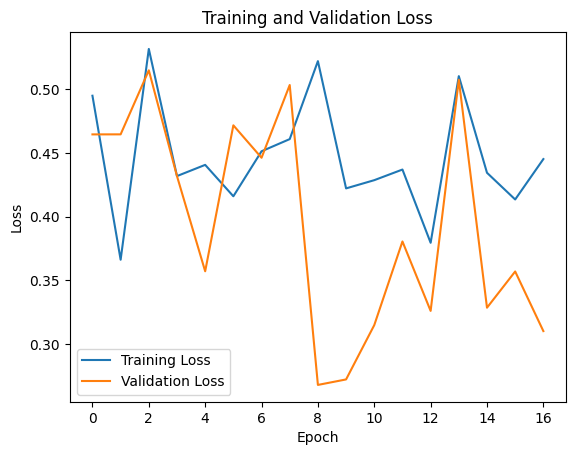

In [35]:
from tensorflow.keras.callbacks import TensorBoard
# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="./logs")
# Train the model with TensorBoard callback
history = model_4.fit(train_generator, steps_per_epoch=10, epochs=20, callbacks=[es, rp, tensorboard_callback], validation_data=valid_generator)
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
model_4.save_weights(filepath="/content/gdrive/MyDrive/Training/model_weights/vgg19_model_4.weights.h5", overwrite=True)

In [37]:
model_4.load_weights("/content/gdrive/MyDrive/Training/model_weights/vgg19_model_4.weights.h5")
vgg_val_eval_4 = model_4.evaluate(valid_generator)
vgg_test_eval_4 = model_4.evaluate(test_generator)
print(f'Validation Loss: {vgg_val_eval_4[0]}')
print(f'Validation Acc: {vgg_val_eval_4[1]}')
print(f'Testing Loss: {vgg_test_eval_4[0]}')
print(f'Testing Acc: {vgg_test_eval_4[1]}')

19/19 [==============================] - 6s 331ms/step - loss: 0.4700 - accuracy: 0.8507
Validation Loss: 0.3102870285511017
Validation Acc: 0.8742724061012268
Testing Loss: 0.4699934124946594
Testing Acc: 0.8507462739944458


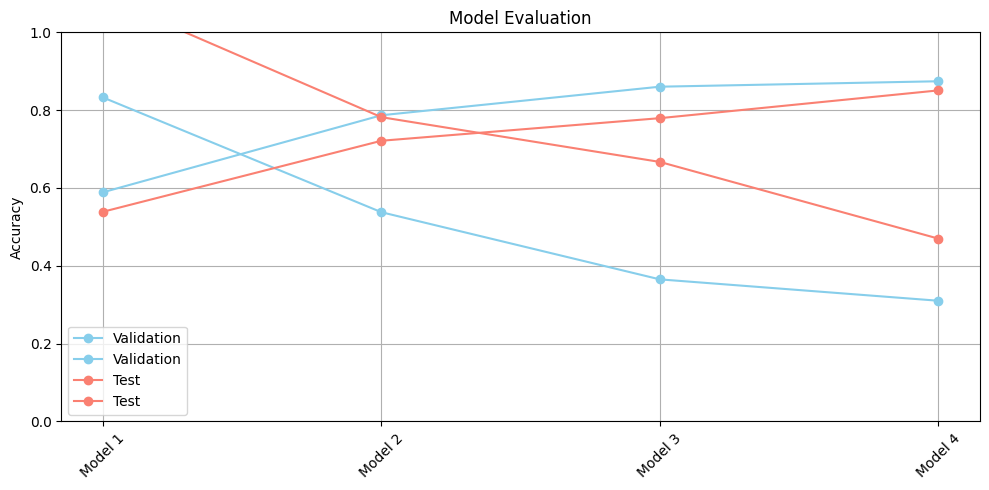

In [38]:
# Evaluation results
val_eval = [vgg_val_eval_1, vgg_val_eval_2, vgg_val_eval_3,vgg_val_eval_4]
test_eval = [vgg_test_eval_1, vgg_test_eval_2, vgg_test_eval_3,vgg_test_eval_4]

# Models labels
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Plotting
plt.figure(figsize=(10, 5))

# Validation results
plt.plot(models, val_eval, marker='o', linestyle='-', color='skyblue', label='Validation')
# Test results
plt.plot(models, test_eval, marker='o', linestyle='-', color='salmon', label='Test')

plt.title('Model Evaluation')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# unfreeze some other layers

In [39]:
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_5',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [54]:
#building new model
base_model = VGG19(include_top = False, input_shape=(240,240,3))

# Flatten the output of VGG19 base
flatten_layer = Flatten()(base_model.output)

# Add my own classification layers
class_1 = Dense(4608, activation = 'relu')(flatten_layer)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)

# Output layer
output_layer = Dense(4, activation='softmax')(class_2)

# Create model
model_5 = Model(inputs=base_model.input, outputs=output_layer)
model_5.load_weights('/content/gdrive/MyDrive/Training/model_weights/vgg19_model_4.weights.h5')
set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3','block5_conv2','block5_conv1','block5_pool']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

In [55]:
# optimizer
learning_rate = 0.001
momentum = 0.9
nesterov = True
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)

model_5.compile( optimizer = sgd, loss='categorical_crossentropy', metrics=['accuracy'])
print(model_5.summary())

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0  

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.3864 - accuracy: 0.8656

10/10 [==============================] - 15s 1s/step - loss: 0.3864 - accuracy: 0.8656 - val_loss: 0.2669 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.8781

10/10 [==============================] - 12s 1s/step - loss: 0.3576 - accuracy: 0.8781 - val_loss: 0.3062 - val_accuracy: 0.8847 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.8281

10/10 [==============================] - 17s 2s/step - loss: 0.4712 - accuracy: 0.8281 - val_loss: 0.3077 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.8562

10/10 [==============================] - 13s 1s/step - loss: 0.3818 - accuracy: 0.8562 - val_loss: 0.3066 - val_accuracy: 0.8801 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - ETA: 0s - loss: 0.4001 - accuracy: 0.8531

10/10 [==============================] - 12s 1s/step - loss: 0.4001 - accuracy: 0.8531 - val_loss: 0.5251 - val_accuracy: 0.7939 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.8531

10/10 [==============================] - 16s 2s/step - loss: 0.3901 - accuracy: 0.8531 - val_loss: 0.4501 - val_accuracy: 0.8370 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - ETA: 0s - loss: 0.3680 - accuracy: 0.8656

10/10 [==============================] - 13s 1s/step - loss: 0.3680 - accuracy: 0.8656 - val_loss: 0.2677 - val_accuracy: 0.8952 - lr: 0.0010
Epoch 8/20
10/10 [==============================] - ETA: 0s - loss: 0.4483 - accuracy: 0.8313

10/10 [==============================] - 12s 1s/step - loss: 0.4483 - accuracy: 0.8313 - val_loss: 0.4589 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 9/20
10/10 [==============================] - ETA: 0s - loss: 0.4386 - accuracy: 0.8344

10/10 [==============================] - 13s 1s/step - loss: 0.4386 - accuracy: 0.8344 - val_loss: 0.3206 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 9: early stopping


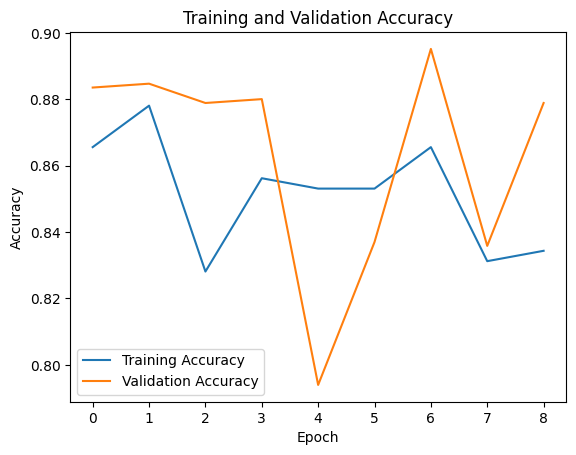

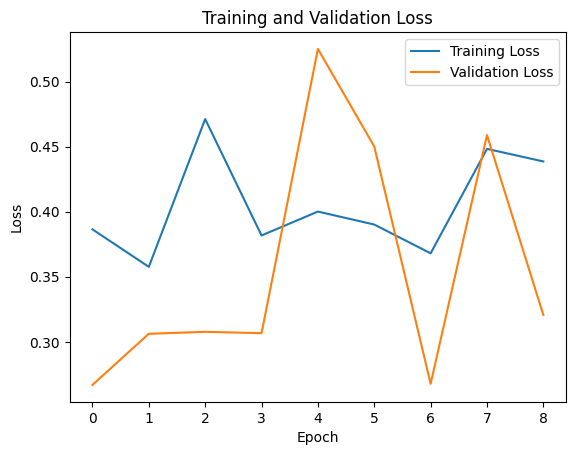

In [56]:
from tensorflow.keras.callbacks import TensorBoard
# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="./logs")
# Train the model with TensorBoard callback
history = model_5.fit(train_generator, steps_per_epoch=10, epochs=20, callbacks=[es, rp, tensorboard_callback], validation_data=valid_generator)
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
model_5.save_weights(filepath="/content/gdrive/MyDrive/Training/model_weights/vgg19_model_5.weights.h5", overwrite=True)

In [58]:
model_5.load_weights("/content/gdrive/MyDrive/Training/model_weights/vgg19_model_5.weights.h5")
vgg_val_eval_5 = model_5.evaluate(valid_generator)
vgg_test_eval_5 = model_5.evaluate(test_generator)
print(f'Validation Loss: {vgg_val_eval_5[0]}')
print(f'Validation Acc: {vgg_val_eval_5[1]}')
print(f'Testing Loss: {vgg_test_eval_5[0]}')
print(f'Testing Acc: {vgg_test_eval_5[1]}')

19/19 [==============================] - 3s 177ms/step - loss: 0.4726 - accuracy: 0.8524
Validation Loss: 0.32062846422195435
Validation Acc: 0.8789289593696594
Testing Loss: 0.4726366102695465
Testing Acc: 0.8524046540260315


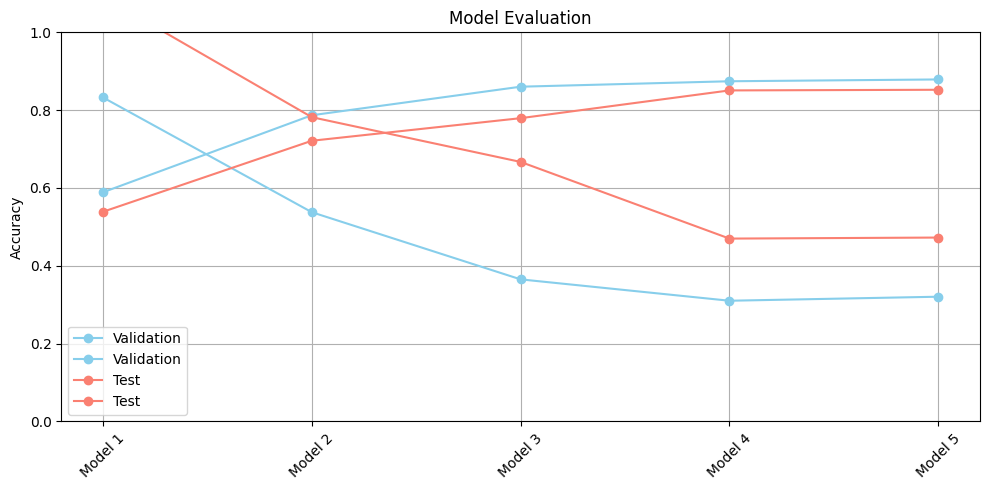

In [59]:
# Evaluation results
val_eval = [vgg_val_eval_1, vgg_val_eval_2, vgg_val_eval_3,vgg_val_eval_4,vgg_val_eval_5]
test_eval = [vgg_test_eval_1, vgg_test_eval_2, vgg_test_eval_3,vgg_test_eval_4,vgg_test_eval_5]

# Models labels
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4','Model 5']

# Plotting
plt.figure(figsize=(10, 5))

# Validation results
plt.plot(models, val_eval, marker='o', linestyle='-', color='skyblue', label='Validation')
# Test results
plt.plot(models, test_eval, marker='o', linestyle='-', color='salmon', label='Test')

plt.title('Model Evaluation')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [60]:
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_14',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [77]:
#building new model
base_model = VGG19(include_top = False, input_shape=(240,240,3))

# Flatten the output of VGG19 base
flatten_layer = Flatten()(base_model.output)

# Add my own classification layers
class_1 = Dense(4608, activation = 'relu')(flatten_layer)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)

# Output layer
output_layer = Dense(4, activation='softmax')(class_2)

# Create model
model_6 = Model(inputs=base_model.input, outputs=output_layer)
model_6.load_weights('/content/gdrive/MyDrive/Training/model_weights/vgg19_model_5.weights.h5')
set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3','block5_conv2','block5_conv1','block5_pool']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

In [78]:
# optimizer
learning_rate = 0.001
momentum = 0.9
nesterov = True
sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)

model_6.compile( optimizer = sgd, loss='categorical_crossentropy', metrics=['accuracy'])
print(model_6.summary())

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0  

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.8531

10/10 [==============================] - 15s 1s/step - loss: 0.4058 - accuracy: 0.8531 - val_loss: 0.3023 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.4118 - accuracy: 0.8438

10/10 [==============================] - 12s 1s/step - loss: 0.4118 - accuracy: 0.8438 - val_loss: 0.2742 - val_accuracy: 0.8894 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.3272 - accuracy: 0.8875

10/10 [==============================] - 12s 1s/step - loss: 0.3272 - accuracy: 0.8875 - val_loss: 0.2863 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.3783 - accuracy: 0.8594

10/10 [==============================] - 13s 1s/step - loss: 0.3783 - accuracy: 0.8594 - val_loss: 0.3457 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - ETA: 0s - loss: 0.4052 - accuracy: 0.8469

10/10 [==============================] - 13s 1s/step - loss: 0.4052 - accuracy: 0.8469 - val_loss: 0.7378 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 6/20
10/10 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.8781

10/10 [==============================] - 13s 1s/step - loss: 0.3318 - accuracy: 0.8781 - val_loss: 0.4497 - val_accuracy: 0.8254 - lr: 0.0010
Epoch 7/20
10/10 [==============================] - ETA: 0s - loss: 0.4148 - accuracy: 0.8625

10/10 [==============================] - 12s 1s/step - loss: 0.4148 - accuracy: 0.8625 - val_loss: 0.2739 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 8/20
10/10 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.8656

10/10 [==============================] - 12s 1s/step - loss: 0.3654 - accuracy: 0.8656 - val_loss: 0.4495 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 9/20
10/10 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.8656

10/10 [==============================] - 16s 2s/step - loss: 0.3666 - accuracy: 0.8656 - val_loss: 0.3698 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 10/20
10/10 [==============================] - ETA: 0s - loss: 0.3140 - accuracy: 0.8875

10/10 [==============================] - 12s 1s/step - loss: 0.3140 - accuracy: 0.8875 - val_loss: 0.3780 - val_accuracy: 0.8580 - lr: 0.0010
Epoch 11/20
10/10 [==============================] - ETA: 0s - loss: 0.3762 - accuracy: 0.8594

10/10 [==============================] - 12s 1s/step - loss: 0.3762 - accuracy: 0.8594 - val_loss: 0.3686 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 12/20
10/10 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8781

10/10 [==============================] - 14s 1s/step - loss: 0.3250 - accuracy: 0.8781 - val_loss: 0.3073 - val_accuracy: 0.8894 - lr: 0.0010
Epoch 13/20
10/10 [==============================] - ETA: 0s - loss: 0.3637 - accuracy: 0.8719

10/10 [==============================] - 12s 1s/step - loss: 0.3637 - accuracy: 0.8719 - val_loss: 0.2182 - val_accuracy: 0.9092 - lr: 0.0010
Epoch 14/20
10/10 [==============================] - ETA: 0s - loss: 0.3843 - accuracy: 0.8500

10/10 [==============================] - 11s 1s/step - loss: 0.3843 - accuracy: 0.8500 - val_loss: 0.2842 - val_accuracy: 0.8801 - lr: 0.0010
Epoch 15/20
10/10 [==============================] - ETA: 0s - loss: 0.3639 - accuracy: 0.8594

10/10 [==============================] - 12s 1s/step - loss: 0.3639 - accuracy: 0.8594 - val_loss: 0.2577 - val_accuracy: 0.8894 - lr: 0.0010
Epoch 16/20
10/10 [==============================] - ETA: 0s - loss: 0.3948 - accuracy: 0.8313

10/10 [==============================] - 12s 1s/step - loss: 0.3948 - accuracy: 0.8313 - val_loss: 0.3102 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 17/20
10/10 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.8813

10/10 [==============================] - 13s 1s/step - loss: 0.3035 - accuracy: 0.8813 - val_loss: 0.2953 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 18/20
10/10 [==============================] - ETA: 0s - loss: 0.3428 - accuracy: 0.8750

10/10 [==============================] - 16s 2s/step - loss: 0.3428 - accuracy: 0.8750 - val_loss: 0.3846 - val_accuracy: 0.8568 - lr: 0.0010
Epoch 19/20
10/10 [==============================] - ETA: 0s - loss: 0.3443 - accuracy: 0.8750

10/10 [==============================] - 13s 1s/step - loss: 0.3443 - accuracy: 0.8750 - val_loss: 0.2724 - val_accuracy: 0.8941 - lr: 0.0010
Epoch 20/20
10/10 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.8938

10/10 [==============================] - 13s 1s/step - loss: 0.3162 - accuracy: 0.8938 - val_loss: 0.2443 - val_accuracy: 0.8999 - lr: 0.0010


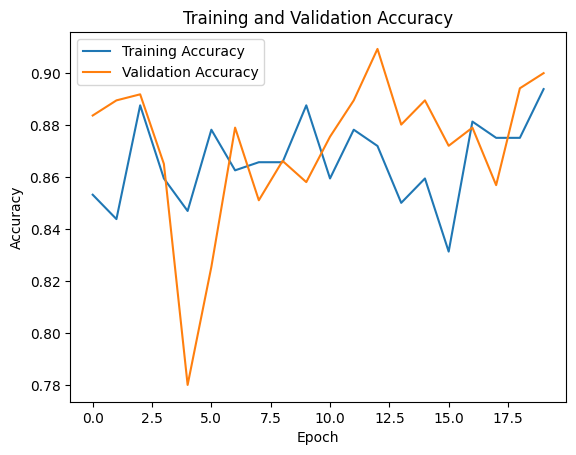

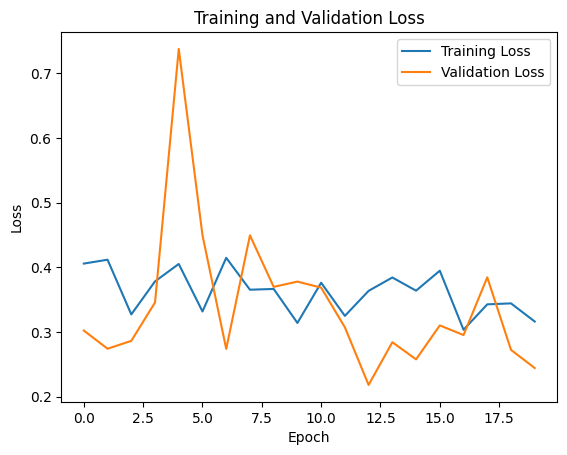

In [79]:
from tensorflow.keras.callbacks import TensorBoard
# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir="./logs")
# Train the model with TensorBoard callback
history = model_6.fit(train_generator, steps_per_epoch=10, epochs=20, callbacks=[es, rp, tensorboard_callback], validation_data=valid_generator)
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:
model_6.save_weights(filepath="/content/gdrive/MyDrive/Training/model_weights/vgg19_model_6.weights.h5", overwrite=True)

In [81]:
model_6.load_weights("/content/gdrive/MyDrive/Training/model_weights/vgg19_model_6.weights.h5")
vgg_val_eval_6 = model_6.evaluate(valid_generator)
vgg_test_eval_6 = model_6.evaluate(test_generator)
print(f'Validation Loss: {vgg_val_eval_6[0]}')
print(f'Validation Acc: {vgg_val_eval_6[1]}')
print(f'Testing Loss: {vgg_test_eval_6[0]}')
print(f'Testing Acc: {vgg_test_eval_6[1]}')

19/19 [==============================] - 4s 219ms/step - loss: 0.4513 - accuracy: 0.8557
Validation Loss: 0.24429857730865479
Validation Acc: 0.8998835682868958
Testing Loss: 0.4512934386730194
Testing Acc: 0.8557214140892029


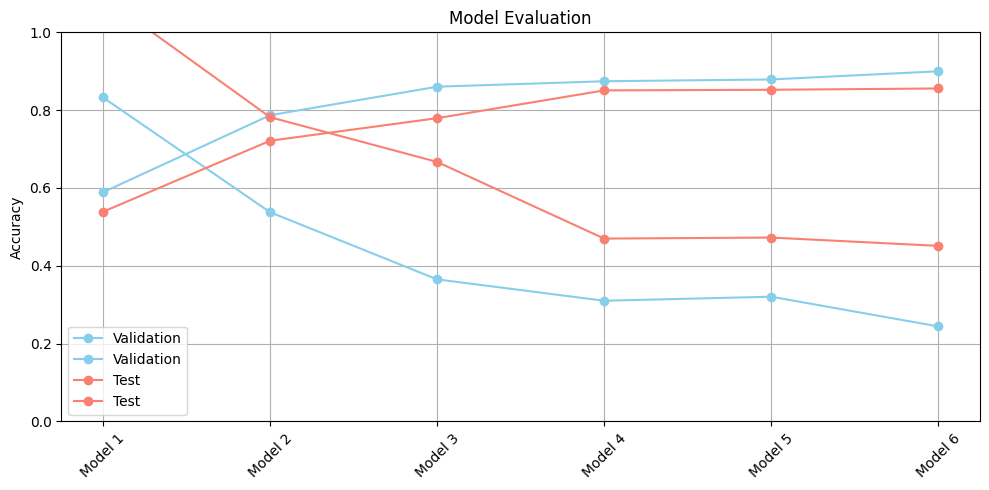

In [82]:
# Evaluation results
val_eval = [vgg_val_eval_1, vgg_val_eval_2, vgg_val_eval_3,vgg_val_eval_4,vgg_val_eval_5,vgg_val_eval_6]
test_eval = [vgg_test_eval_1, vgg_test_eval_2, vgg_test_eval_3,vgg_test_eval_4,vgg_test_eval_5,vgg_test_eval_6]

# Models labels
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4','Model 5','Model 6']

# Plotting
plt.figure(figsize=(10, 5))

# Validation results
plt.plot(models, val_eval, marker='o', linestyle='-', color='skyblue', label='Validation')
# Test results
plt.plot(models, test_eval, marker='o', linestyle='-', color='salmon', label='Test')

plt.title('Model Evaluation')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()